In [1]:
import sys
from pathlib import Path

import h5py as h5
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('../../lib')
from local_paths import analysis_dir

# Parameters

In [2]:
#============================================================================
# analysis type and result path
#============================================================================
# - stim onset-aligned
# analysis_name = 'stim_on'
# results_subdir = 'fix0_self_consistency_boot200-t2hh'

# - OR, fixation onset-aligned
analysis_name = 'fix_on'
results_subdir ='self_consistency_boot200-cp'

output_sfx = ''

#============================================================================
# selection criteria
#============================================================================
boots_spread = 25
min_clearance = 100
min_boots_frac = 0.5

# lower-clip stim-on latency at 0?  only relevant if analysis_name == stim_on
clamp_stim_on = True

In [3]:
# Parameters
analysis_name = "fix_on"
results_subdir = "self_consistency_boot200-cp"
output_sfx = "-more"
boots_spread = 50
min_boots_frac = 0.25


# Preamble

In [4]:
results_dir = Path(analysis_dir+results_subdir).expanduser()
assert results_dir.is_dir()

if analysis_name == 'fix_on':
    res_tag = results_dir.stem.replace('self_consistency_boot200-cp', '')
else:
    res_tag = results_dir.stem.replace('fix0_self_consistency_boot200-t2hh', '')
if res_tag:
    res_tag = '-' + res_tag
print('results name tag:', res_tag)

clamp_stim_on = clamp_stim_on and (analysis_name == 'stim_on')

cols_to_save = ['Latency', 'Boots. stdev.', 'Clearance', 'T step', 'Boots. frac.']
if analysis_name == 'fix_on':
    cols_to_save += ['Peak 0 SC', 'Peak 0 time', 'Peak 1 SC', 'Peak 1 time']
else:
    cols_to_save += ['Peak SC', 'Peak time']

results name tag: 


# Load data

In [5]:
df = []
for fp in results_dir.glob('*.h5'):
    with h5.File(fp, 'r') as f:
        try:
            if analysis_name == 'fix_on':
                assert f['progress_report/crossing_point/all_done'][()]
            else:
                assert f['progress_report/time_to_half_height/all_done'][()]
        except (KeyError, AssertionError):
            continue

    if analysis_name == 'fix_on':
        df_ = pd.read_hdf(fp, 'crossing_point/latency_dataframe')
    else:
        try:
            df_ = pd.read_hdf(fp, 'time_to_half_height/return_fixation/latency_dataframe')
        except KeyError:
            continue

    df.append(df_)

df = pd.concat(df).set_index(['Session', 'Level', 'Name'])
assert not df.index.has_duplicates
print(df.shape)

(78034, 32)


# Select from all results

In [6]:
def select_latetency(
        lat_df, analysis_name=analysis_name,
        min_boots_frac=min_boots_frac, boots_spread=boots_spread,
        min_clearance=min_clearance,
        clamp_stim_on=clamp_stim_on):

    df = lat_df.copy()
    criteria = {}
    criteria['Is valid'] = np.isfinite(lat_df['Latency'].values)

    criteria['Clearance'] = lat_df['Clearance'].values >= min_clearance
    if analysis_name == 'fix_on':
        criteria['Peak time'] = (
            (lat_df['Latency'].values >= lat_df['Peak 0 time'].values)
            & (lat_df['Latency'].values <= lat_df['Peak 1 time'].values))
    else:
        criteria['Peak time'] = lat_df['Latency'].values <= lat_df['Peak time'].values

    if clamp_stim_on:
        criteria['Is positive'] = lat_df['Latency'].values > 0

    criteria['Boots. frac.'] = lat_df['Boots. frac., train'].values >= min_boots_frac
    criteria['Boots. spread'] = (
        (np.abs(lat_df['Boots. bias, train'].values) < boots_spread)
        & (lat_df['Boots. stdev., train'].values < boots_spread))
    criteria['Boots. clearance'] = lat_df['Boots. mean clearance, train'].values >= min_clearance

    for k, m in criteria.items():
        print(f'criterion: {k:<20} passed: {m.mean()*100:.1f}% ({m.sum()} of {m.size})')
    m = np.all(list(criteria.values()), axis=0)
    print(f'criterion: {"All":<20} passed: {m.mean()*100:.1f}% ({m.sum()} of {m.size})')

    return m

In [7]:
lat_df = df.copy()
lat_df['Selected'] = select_latetency(lat_df)

criterion: Is valid             passed: 98.1% (76562 of 78034)
criterion: Clearance            passed: 26.5% (20663 of 78034)
criterion: Peak time            passed: 48.2% (37592 of 78034)
criterion: Boots. frac.         passed: 98.5% (76855 of 78034)
criterion: Boots. spread        passed: 78.9% (61584 of 78034)
criterion: Boots. clearance     passed: 17.4% (13592 of 78034)
criterion: All                  passed: 9.8% (7644 of 78034)


In [8]:
lat_df.loc[lat_df['Selected'], cols_to_save].to_csv(
    f'summary/{analysis_name}_latency{res_tag}{output_sfx}.csv.gz')

# Summarize array-level results

In [9]:
arreg = pd.read_csv('../../db/bank_array_regions.csv').astype({'Array ID': str})
arreg['Subject'] = [v[:2] for v in arreg['Session']]
arreg = arreg.groupby(['Subject', 'Array ID']).first()

In [10]:
lat_df = df.reset_index()
lat_df = lat_df[lat_df['Level']=='Array'].copy()
lat_df['Selected'] = select_latetency(lat_df)

criterion: Is valid             passed: 99.6% (1128 of 1132)
criterion: Clearance            passed: 58.5% (662 of 1132)
criterion: Peak time            passed: 70.6% (799 of 1132)
criterion: Boots. frac.         passed: 100.0% (1132 of 1132)
criterion: Boots. spread        passed: 72.0% (815 of 1132)
criterion: Boots. clearance     passed: 59.8% (677 of 1132)
criterion: All                  passed: 36.8% (417 of 1132)


In [11]:
adf = lat_df[lat_df['Selected']].copy()
adf['Subject'] = [v[:2] for v in adf['Session']]
adf['Region'] = arreg.loc[list(map(tuple, adf[['Subject', 'Name']].values))]['Region'].values

Array-level latencies, per session


<Axes: xlabel='Latency', ylabel='Density'>

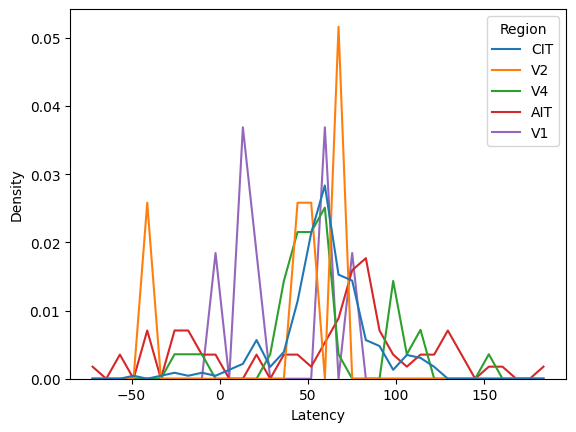

In [12]:
print('Array-level latencies, per session')
sns.histplot(data=adf, x='Latency', hue='Region', stat='density', element='poly', common_norm=False, fill=False)

Array-level latencies, per session
After selecting for test boots frac


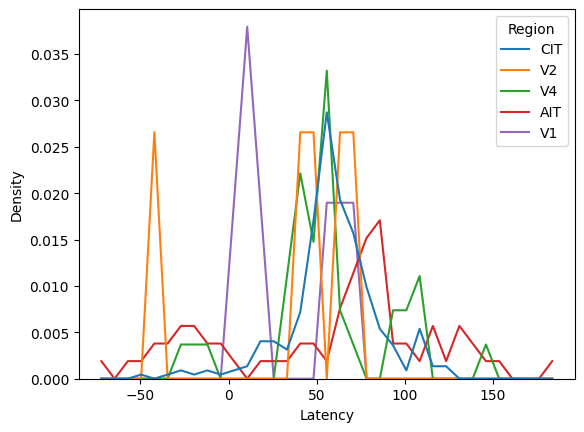

In [13]:
print('Array-level latencies, per session')
print('After selecting for test boots frac')
# note here and below, we select based on test boots frac because
# 1) array-level results are never reported but used as default parameters
# 2) as default parameters, the values should be reliable
adf = adf[adf['Boots. stdev.'] < boots_spread]  # select once
sns.histplot(data=adf, x='Latency', hue='Region', stat='density', element='poly', common_norm=False, fill=False);

Array-level latencies, median across sessions


Latency Region  Selected  Boots. stdev.
Subject Name                                            
An      1      58.867126     V1       1.0      22.595963
Bf      6     -25.857143    AIT       1.0      46.398739
Bo      3      69.325912    AIT       1.0      18.965178
Fr      0      77.000000    CIT       1.0      20.740201
        1      53.695652    CIT       1.0      41.801871
        3      50.280235     V4       1.0       4.904025
Lo      0      71.949997    CIT       1.0      25.166542
        1      57.132286    CIT       1.0      22.456321
        2      81.301369    CIT       1.0      26.635993
Na      0      48.414635     V2       1.0      24.796373
        1      67.688889     V4       1.0      26.651882
Oc      6      40.000000    AIT       1.0      25.176294
        7      59.890110    AIT       1.0      31.080762
Ot      5       6.274900    CIT       1.0      12.135744
Pa      0      10.033557     V1       1.0      11.336017
        1      57.975845    CIT       1.0       4.457617
        2      54.676765    CIT       1.0      12.246913
Re      3      52.777779    CIT       1.0      41.499111
        6     105.986717    AIT       1.0      16.790178
Sw      1      16.980198    CIT       1.0      27.840190
Ve      2     118.000000    AIT       1.0      18.558948
        3     157.000000    AIT       1.0      17.940790
Ye      0     101.000000    CIT       1.0      11.263652
        1      48.908119    CIT       1.0      25.263183

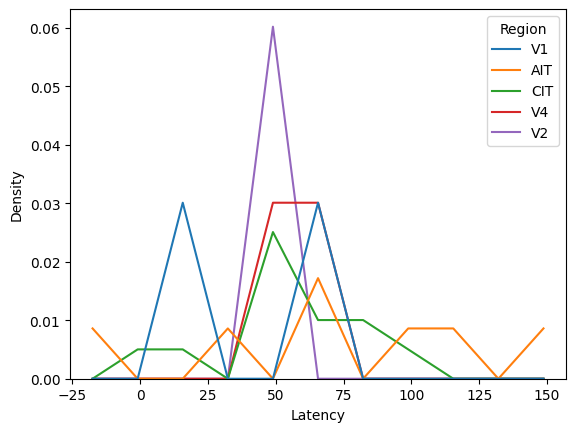

In [14]:
print('Array-level latencies, median across sessions')
df_ = adf.groupby(['Subject', 'Name']).agg({
    'Latency': 'median', 'Region': 'first', 'Selected': 'mean', 'Boots. stdev.': 'median'})
assert df_['Selected'].all()  # sanity check
df_ = df_[df_['Boots. stdev.'] < boots_spread]
sns.histplot(data=df_, x='Latency', hue='Region', stat='density', element='poly', common_norm=False, fill=False);
df_

In [15]:
print('Array-level latencies, median across arrays')
df_.groupby('Region').median()

Array-level latencies, median across arrays


,Latency,Selected,Boots. stdev.
Region,,,
AIT,69.325912,1.0,18.965178
CIT,55.904526,1.0,23.811432
V1,34.450340,1.0,16.965990
V2,48.414635,1.0,24.796373
V4,58.984562,1.0,15.777953


In [16]:
# save array-level resuilts median across sessions
gb = adf.groupby(['Subject', 'Name'])
df_ = gb[cols_to_save].median()
df_['Count'] = gb['Latency'].count()
df_['Region'] = gb['Region'].first()
df_['Level'] = 'Array'
df_ = df_[df_['Boots. stdev.'] < boots_spread]  # select twice
df_ = df_.reset_index().set_index(['Subject', 'Level', 'Name'])
df_.to_csv(f'summary/{analysis_name}_latency{res_tag}{output_sfx}-array_level.csv.gz')
df_

Latency  Boots. stdev.   Clearance  T step   
Subject Level Name                                                  
An      Array 1      58.867126      22.595963  246.644684    10.0  \
Bf      Array 6     -25.857143      46.398739  122.000000    10.0   
Bo      Array 3      69.325912      18.965178  294.129578    10.0   
Fr      Array 0      77.000000      20.740201  252.774307    10.0   
              1      53.695652      41.801871  169.095657    10.0   
              3      50.280235       4.904025  305.269226    10.0   
Lo      Array 0      71.949997      25.166542  251.216492    10.0   
              1      57.132286      22.456321  248.009628    10.0   
              2      81.301369      26.635993  249.541290    10.0   
Na      Array 0      48.414635      24.796373  203.503403    10.0   
              1      67.688889      26.651882  235.085464    10.0   
Oc      Array 6      40.000000      25.176294  280.731720    10.0   
              7      59.890110      31.080762  268.767029    10.0   
Ot      Array 5       6.274900      12.135744  175.573959    10.0   
Pa      Array 0      10.033557      11.336017  190.844452    10.0   
              1      57.975845       4.457617  299.717865    10.0   
              2      54.676765      12.246913  301.038605    10.0   
Re      Array 3      52.777779      41.499111  312.222229    10.0   
              6     105.986717      16.790178  249.336334    10.0   
Sw      Array 1      16.980198      27.840190  196.935898    10.0   
Ve      Array 2     118.000000      18.558948  230.000000    10.0   
              3     157.000000      17.940790  208.000000    10.0   
Ye      Array 0     101.000000      11.263652  312.000000    10.0   
              1      48.908119      25.263183  319.931000    10.0   

                    Boots. frac.  Peak 0 SC  Peak 0 time  Peak 1 SC   
Subject Level Name                                                    
An      Array 1              1.0   0.199707        -40.0   0.151855  \
Bf      Array 6              1.0   0.064453       -315.0   0.059570   
Bo      Array 3              1.0   0.359863        -65.0   0.488770   
Fr      Array 0              1.0   0.228516        -75.0   0.228516   
              1              1.0   0.194336        -35.0   0.282227   
              3              1.0   0.289062        -15.0   0.367188   
Lo      Array 0              1.0   0.324219        -75.0   0.473633   
              1              1.0   0.265625        -75.0   0.385742   
              2              1.0   0.189453        -25.0   0.236328   
Na      Array 0              1.0   0.223633       -145.0   0.263672   
              1              1.0   0.341797       -105.0   0.261719   
Oc      Array 6              1.0   0.218750        -75.0   0.338867   
              7              1.0   0.135742        -10.0   0.125977   
Ot      Array 5              1.0   0.419922        -95.0   0.733398   
Pa      Array 0              1.0   0.290039        -85.0   0.249023   
              1              1.0   0.346680        -65.0   0.443848   
              2              1.0   0.254883        -55.0   0.334961   
Re      Array 3              1.0   0.104492          5.0   0.150391   
              6              1.0   0.428223        -20.0   0.406738   
Sw      Array 1              1.0   0.262695       -105.0   0.381836   
Ve      Array 2              1.0   0.256836        -55.0   0.204102   
              3              1.0   0.175781        -55.0   0.167969   
Ye      Array 0              1.0   0.136719        -65.0   0.210938   
              1              1.0   0.175293       -105.0   0.316406   

                    Peak 1 time  Count Region  
Subject Level Name                             
An      Array 1           155.0      4     V1  
Bf      Array 6           215.0      1    AIT  
Bo      Array 3           135.0     38    AIT  
Fr      Array 0           165.0     19    CIT  
              1           155.0      5    CIT  
              3           105.0     19     V4